<a href="https://colab.research.google.com/github/narcisocabraljr/Tech_Challenge_1/blob/main/Tech_Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A análise deste Dataset tem como objetivo prever se uma pessoa possui chances de ter um Acidente Vascular Cerebral (AVC), os dados contidos no Dataset são:


*   id: identificador único para cada paciente, será desconsiderado para as estatísticas
*   gender: Gênero registrado pelo paciente, sendo "Feminino", "Masculino" ou "Outro"
*   age: Idade do Paciente
*   hypertension: campo binário para validar se o paciente possui hipertensão ou não
*   heart_disease: campo binário para validar se o paciente possui doenças cardíacas
*   ever_married: campo binário para validar se o paciente é casado
*   work_type: Campo para validar o tipo de profissão que o paciente exerce, podendo ser "privado", "público", "autônomo", "nunca trabalhou" ou "criança"
*   Residence_type: campo para validar se o paciente vive em uma zona rural ou urbana
*   avg_glucose_level: Campo que contém os níveis médios de glicose do paciente
*   bmi: campo com o valor de IMC (Índice de Massa Corporal) do paciente
*   smoking_status: campo para validar se o paciente fuma ou já fumou anteriormente
*   stroke: variável "target" que indica se o paciente é propenso a um AVC ou não


Começamos importando algumas bibliotecas básicas

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# Opção 2
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

Vamos agora carregar o dataset de previsão de derrames:

In [2]:
dados = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [ ]:
dados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Conseguimos observar que existem algumas variáveis categóricas que deverão ser tratadas, vamos observar se há linhas vazias no dataset:

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
dados.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


No campo "bmi" temos 201 linhas vazias que iremos tratar para obter os melhores resultados. Vamos remover a coluna "id", que não será relevante para nossa análise, e depois montar um histograma para observar a distribuição dos dados.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>],
       [<Axes: title={'center': 'heart_disease'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'stroke'}>]], dtype=object)

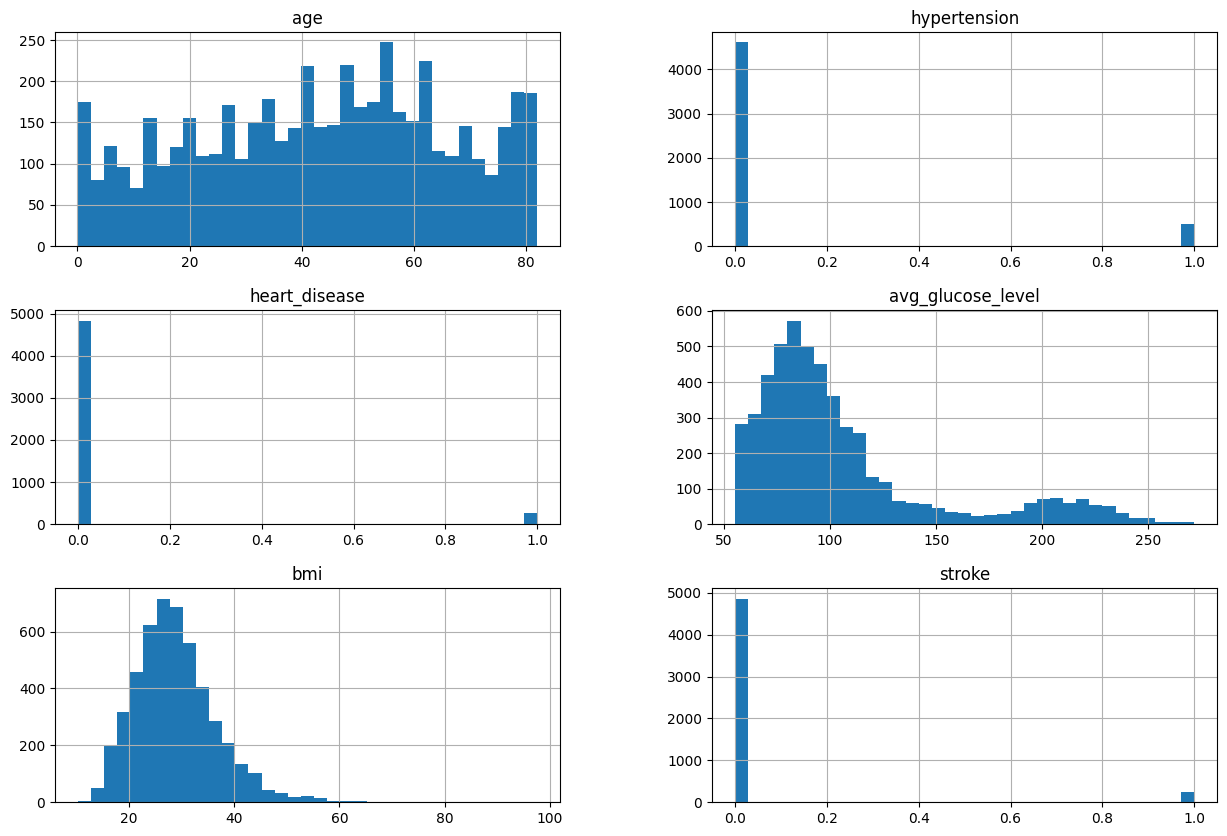

In [5]:
tratamento = dados.drop("id",axis=1)
tratamento.hist(bins=35, figsize=(15,10))

Podemos observar que alguns campos possuem valores concentrados, como por exemplo o campo "heart_disease" onde há muito mais linhas com o valor 0 do que com o valor 1

Vamos analisar a correlação entre campos para analisar o peso destes valores no nosso objetivo:

In [6]:
# Selecionar apenas as colunas numéricas para o cálculo da correlação
numeric_df = tratamento.select_dtypes(include=['number'])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()
print("Matriz de Correlação das colunas numéricas:")
print(correlation_matrix)

Matriz de Correlação das colunas numéricas:
                        age  hypertension  heart_disease  avg_glucose_level  \
age                1.000000      0.276398       0.263796           0.238171   
hypertension       0.276398      1.000000       0.108306           0.174474   
heart_disease      0.263796      0.108306       1.000000           0.161857   
avg_glucose_level  0.238171      0.174474       0.161857           1.000000   
bmi                0.333398      0.167811       0.041357           0.175502   
stroke             0.245257      0.127904       0.134914           0.131945   

                        bmi    stroke  
age                0.333398  0.245257  
hypertension       0.167811  0.127904  
heart_disease      0.041357  0.134914  
avg_glucose_level  0.175502  0.131945  
bmi                1.000000  0.042374  
stroke             0.042374  1.000000  


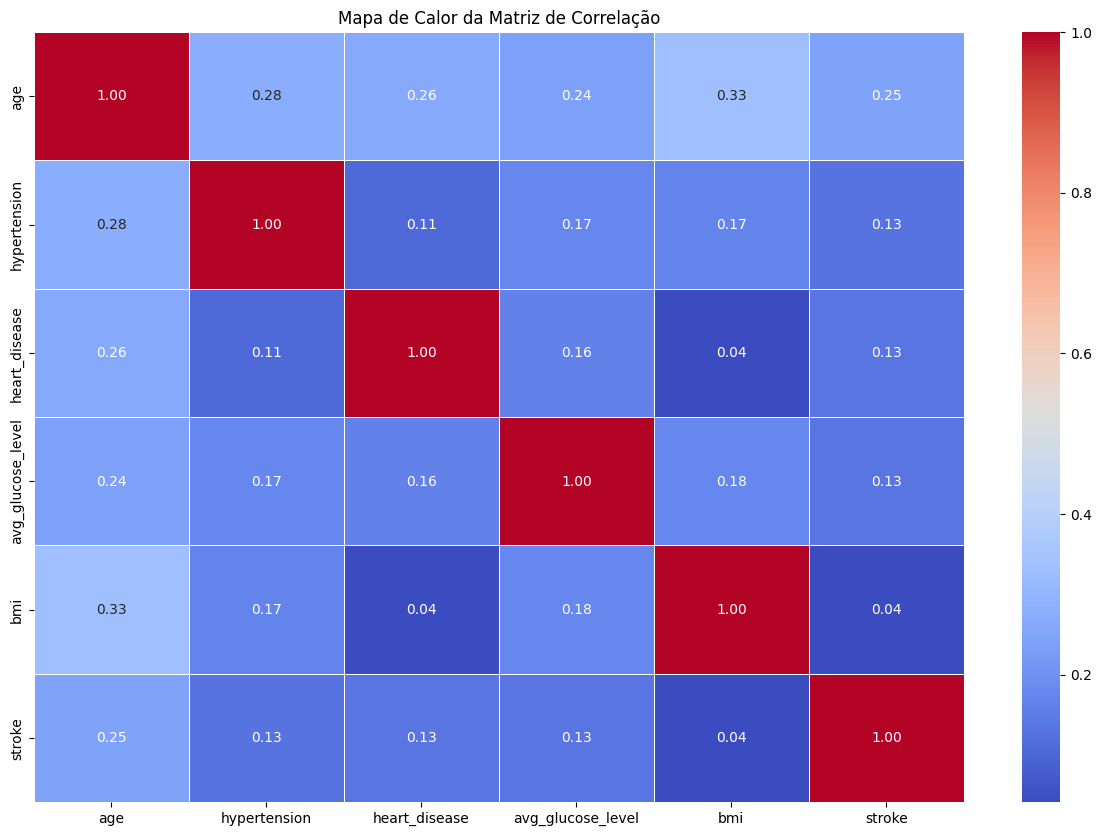

In [7]:
# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(15, 10))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()

A princípio, a idade parece ser um valor importante para determinar a nossa variável target

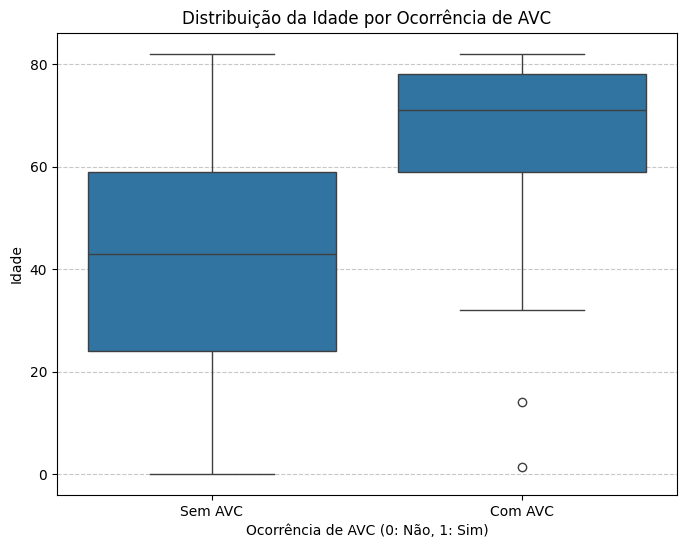

In [8]:
# Cria o box plot
plt.figure(figsize=(8, 6)) # Define o tamanho da figura
sb.boxplot(x='stroke', y='age', data=tratamento)
plt.title('Distribuição da Idade por Ocorrência de AVC')
plt.xlabel('Ocorrência de AVC (0: Não, 1: Sim)')
plt.ylabel('Idade')
plt.xticks([0, 1], ['Sem AVC', 'Com AVC'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show() # Descomente para exibir o gráfico se estiver rodando localmente

Conforme mostrado no gráfico acima, a maior parte dos pacientes que podem ter um AVC estão na faixa acima dos 60 anos. A exceção a esta análise são os 2 "outliers" expressos pelos círculos brancos.

Primeiro, vamos remover a coluna que vamos prever do resto da base:

In [9]:
base = tratamento.drop(columns=["stroke"],axis=1)
target = tratamento["stroke"].copy()

Agora vamos a tratar as variáveis categóricas:

In [10]:
#Coluna gênero
encoder_genero = OneHotEncoder()
onehot_genero = encoder_genero.fit_transform(base[["gender"]])
genero_tratado = pd.DataFrame(onehot_genero.toarray(),columns=encoder_genero.get_feature_names_out(["gender"]),index=base.index)

#Coluna casado
encoder_casado = OneHotEncoder()
onehot_casado = encoder_casado.fit_transform(base[["ever_married"]])
casado_tratado = pd.DataFrame(onehot_casado.toarray(),columns=encoder_casado.get_feature_names_out(["ever_married"]),index=base.index)

#Coluna trabalho
encoder_trabalho = OneHotEncoder()
onehot_trabalho = encoder_trabalho.fit_transform(base[["work_type"]])
trabalho_tratado = pd.DataFrame(onehot_trabalho.toarray(),columns=encoder_trabalho.get_feature_names_out(["work_type"]),index=base.index)

#Coluna tipo residência
encoder_residencia = OneHotEncoder()
onehot_residencia = encoder_residencia.fit_transform(base[["Residence_type"]])
residencia_tratado = pd.DataFrame(onehot_residencia.toarray(),columns=encoder_residencia.get_feature_names_out(["Residence_type"]),index=base.index)

#Coluna Fumante
encoder_fumante = OneHotEncoder()
onehot_fumante = encoder_fumante.fit_transform(base[["smoking_status"]])
fumante_tratado = pd.DataFrame(onehot_fumante.toarray(),columns=encoder_fumante.get_feature_names_out(["smoking_status"]),index=base.index)

#Anexa valores ao dataset
base = pd.concat([base.drop(columns=['gender','ever_married','work_type','Residence_type','smoking_status']), genero_tratado,casado_tratado,trabalho_tratado,residencia_tratado,fumante_tratado], axis=1)



In [11]:
base.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0,0,202.21,NaN,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.5,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0,171.23,34.4,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1,0,174.12,24.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Antes de analisarmos novamente os nossos dados, vamos tratar as linhas vazias da coluna "bmi", para isso, iremos utilizar o Imputer

In [12]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(base)
arr_imputer = imputer.transform(base)
baseCompleta = pd.DataFrame(arr_imputer,columns=base.columns,index=base.index)

In [13]:
baseCompleta.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0.0,0.0,202.21,28.893237,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0.0,1.0,105.92,32.500000,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0.0,0.0,171.23,34.400000,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1.0,0.0,174.12,24.000000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


A segunda linha da base que tinha a coluna BMI vazia agora está preenchida com a média

In [14]:
X = baseCompleta
Y = target
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)


# Métricas
print(f"Acurácia: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(Y_test, y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
print(f"F1-score: {f1_score(Y_test, y_pred):.2f}")
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))

Acurácia: 0.94
Precisão: 0.30
Recall: 0.05
F1-score: 0.08

Matriz de Confusão:
 [[953   7]
 [ 59   3]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.30      0.05      0.08        62

    accuracy                           0.94      1022
   macro avg       0.62      0.52      0.52      1022
weighted avg       0.90      0.94      0.91      1022



Acurácia: 0.78
Precisão: 0.75
Recall: 0.84
F1-score: 0.79

Matriz de Confusão:
 [[36 14]
 [ 8 42]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        50
           1       0.75      0.84      0.79        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



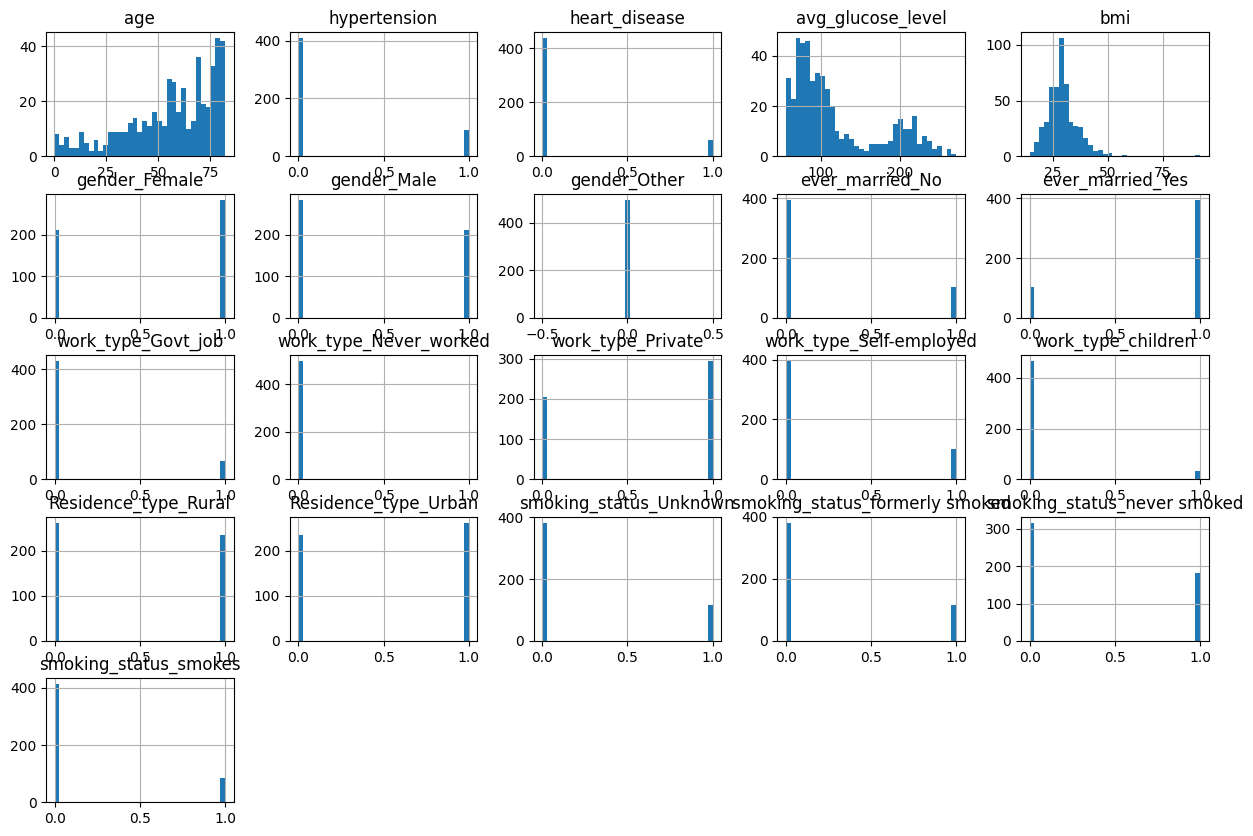

In [38]:
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, Y)
X_res.hist(bins=35, figsize=(15,10))

X_train, X_test, Y_train, Y_test = train_test_split(X_res,y_res, test_size=0.2,stratify=y_res, random_state=42)
#model = KNeighborsClassifier(n_neighbors=5)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)


# Métricas
print(f"Acurácia: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(Y_test, y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
print(f"F1-score: {f1_score(Y_test, y_pred):.2f}")
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))

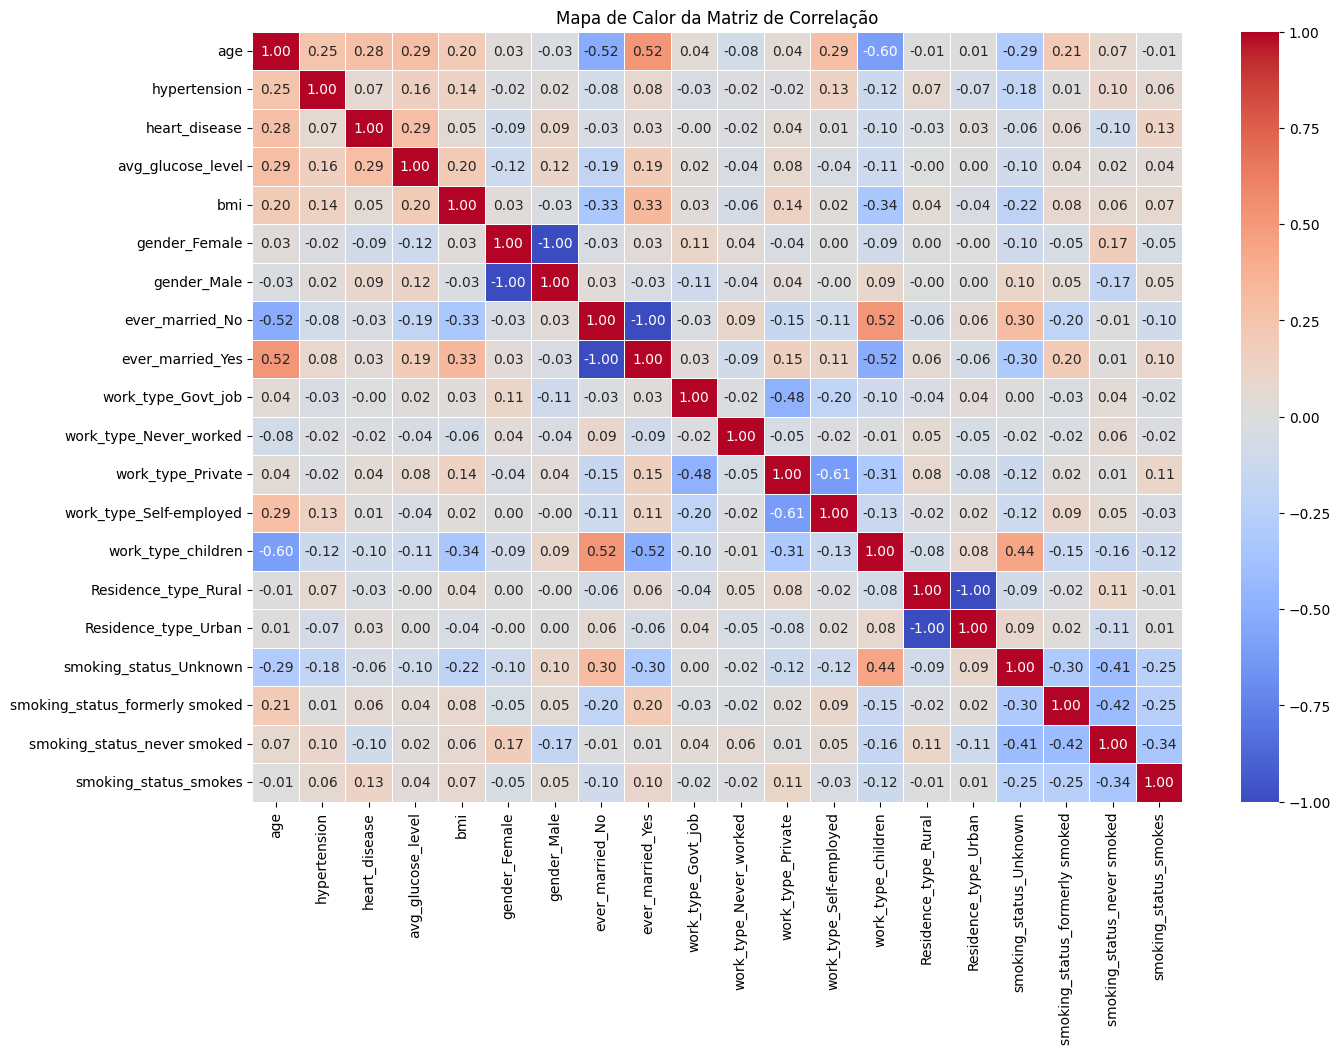

In [36]:
# Calcular a matriz de correlação
correlation_matrix = X_res.corr()
plt.figure(figsize=(15, 10))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()